In [1]:
### SETUP ###
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation

### SET DISPLAY PARAMETERS FOR DATAFRAMES AND PLOTS ###
pd.set_option('display.max_rows', 20)
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Helvetica"

# 2 variables
# Phenotype: Normal, Early Death, Bloated
# Alleles: WT, In-frame, frameshift

In [2]:
### READ IN METADATA LABELING INDIVIDUAL SAMPLES ###
# Must be .csv
# Must have a column "Sample Name" with sample names
# Must have a column "Phenotype" (TODO: change to generic label)

metadata_csv = "genopy_lox5/data_lox5/batchAC_phenotype_metadata.csv"
batch_0AC_phenotype_metadata = pd.read_csv(metadata_csv)
batch_0AC_phenotype_metadata

,Sample Name,Phenotype
0,A1,Normal
1,A2,Normal
2,A3,Bloated
3,A4,Normal
4,A5,Bloated
...,...,...
71,11-lox5_INJ_MED_11_C02_012.fsa,Normal
72,12-lox5_INJ_NONE_12_D02_010.fsa,Normal
73,13-lox5_INJ_NONE_13_E02_008.fsa,Normal
74,14-lox5_INJ_NONE_14_F02_006.fsa,Normal


In [3]:
### READ IN ALL DATA ###
# For Batches A/B/C
exported_data_1 = pd.read_csv("genopy_lox5/data_lox5/lox5_Genotyping_Batches_ABCUninj_021820_2020-02-25_18558_Samples_All.csv")
exported_data_2 = pd.read_csv("genopy_lox5/data_lox5/Lox5T3 genotyping experiment sets A_Samples_1-50.csv")
exported_data_3 = pd.read_csv("genopy_lox5/data_lox5/Lox5T3 genotyping experiment sets A_Samples_51-79.csv")
all_data_123 = pd.concat([exported_data_1, exported_data_2, exported_data_3])
# Insert column with sample name for Batches A/B/C
all_data_123.insert(0, "Sample Name", all_data_123["Sample Filename"].apply(lambda filename : filename.split("-")[1].split("_")[0]))
# SPECIFIC TO THIS NOTEBOOK: Remove Batch B from consideration
all_data_123 = all_data_123[["B" not in sample_name for sample_name in list(all_data_123["Sample Name"])]]


# For Batches WT/NONE/MED/SEV
all_data_wnms = pd.read_csv("genopy_lox5/data_lox5/lox5 Genotyping Analysis 090619_2020-02-28_152143_All_Samples.csv")
# Insert column with sample name for Batches WT/NONE/MED/SEV
all_data_wnms.insert(0, "Sample Name", all_data_wnms["Sample Filename"]) 

In [4]:
### MERGE (CONCATENATE) ALL DATA ###
all_exported_data = pd.concat([all_data_123, all_data_wnms])

### FILTER FOR DESIRED PEAKS ###
# Selects only the BLUE dye color peaks
all_exported_data = all_exported_data[all_exported_data["Dye Color"] == "BLUE"]

In [5]:
### ADD COLUMN WITH ROUNDED PEAK SIZE ###
# Rounds the "Size" values and adds new column; removes "*" in front of "size standard" peak lengths
def round_and_convert(size):
    if "*" in size:
        size = size[1:]
    return round(float(size))


all_exported_data.insert(1, "Rounded Peak Size (bp)", all_exported_data["Size"].apply(round_and_convert))

In [6]:
#Isolate peaks given set constraints on minimum peak height and minimum bp
min_bp = 50
min_height = 750

all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] >= min_bp]
all_exported_data = all_exported_data[all_exported_data["Height"] >= min_height]

# COMMENTED OUT IN THIS NOTEBOOK
#wt_peak_bp_1 = 296
#wt_peak_bp_2 = 297

#all_exported_data.insert(2, "WT Peak (T/F)", all_exported_data["Rounded Peak Size (bp)"].apply(lambda size : size in (wt_peak_bp_1, wt_peak_bp_2)))

#spurious_peaks = all_exported_data
#spurious_peaks.insert(0, "Spurious Peak", spurious_peaks["Rounded Peak Size (bp)"].apply(lambda size : size in (185, 223, 245, 246, 247)))
#spurious_peaks.insert(0, "Spurious Peak", spurious_peaks["Rounded Peak Size (bp)"].apply(lambda size : size in (185, 223, 245, 246, 247)))

all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 195]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 223]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 245]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 246]
all_exported_data = all_exported_data[all_exported_data["Rounded Peak Size (bp)"] != 247]
all_exported_data

,Sample Name,Rounded Peak Size (bp),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12
1,C1,292,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN
9,C1,297,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN
16,C1,75,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN
34,C1,78,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN
44,C1,303,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,09-lox5_INJ_MED_9_A02_016.fsa,306,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 75",305.98,2289.0,14612.0,1187.02,4269.0,4260.0,4278.0,305.25,306.71,NaN
1316,10-lox5_INJ_MED_10_B02_014.fsa,298,10-lox5_INJ_MED_10_B02_014.fsa,BLUE,"B, 75",298.13,801.0,6852.0,555.79,4184.0,4180.0,4195.0,297.81,299.03,NaN
1343,10-lox5_INJ_MED_10_B02_014.fsa,531,10-lox5_INJ_MED_10_B02_014.fsa,BLUE,"B, 85",531.10,908.0,12068.0,1041.28,7002.0,6987.0,7040.0,529.81,534.38,NaN
1347,10-lox5_INJ_MED_10_B02_014.fsa,556,10-lox5_INJ_MED_10_B02_014.fsa,BLUE,"B, 87",555.95,17088.0,206988.0,18570.93,7285.0,7256.0,7314.0,553.35,558.56,NaN


In [7]:
### LABELS EACH READ WITH CORRESPONDING INDIVIDUAL PHENOTYPE BASED ON METADATA ###
all_exported_data = all_exported_data.merge(batch_0AC_phenotype_metadata, left_on = "Sample Name", right_on = "Sample Name")
all_exported_data

,Sample Name,Rounded Peak Size (bp),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Phenotype
0,C1,292,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN,Early Death
1,C1,297,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN,Early Death
2,C1,75,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN,Early Death
3,C1,78,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN,Early Death
4,C1,303,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN,Early Death
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,09-lox5_INJ_MED_9_A02_016.fsa,294,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 68",293.75,30916.0,200557.0,16288.79,4118.0,4109.0,4127.0,293.02,294.48,NaN,Normal
443,09-lox5_INJ_MED_9_A02_016.fsa,297,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 70",297.00,8483.0,57684.0,4680.80,4158.0,4148.0,4168.0,296.19,297.81,NaN,Normal
444,09-lox5_INJ_MED_9_A02_016.fsa,303,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 73",302.90,1240.0,9700.0,783.07,4231.0,4222.0,4235.0,302.17,303.22,NaN,Normal
445,09-lox5_INJ_MED_9_A02_016.fsa,304,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 74",303.87,32575.0,237158.0,19194.15,4243.0,4235.0,4255.0,303.22,304.84,NaN,Normal


In [8]:
### LABELS EACH READ AS WT, FRAMESHIFT, OR INFRAME ###
wt_bp = (297, None)
if_bp = np.arange(0, 1000, 3)

def check_allele(size):
    if size in wt_bp:
        return "Wild-type"
    elif size in if_bp:
        return "Inframe"
    else:
        return "Frameshift"
    
all_exported_data.insert(0, "Allele Categorization", all_exported_data["Rounded Peak Size (bp)"].apply(check_allele))
all_exported_data

,Allele Categorization,Sample Name,Rounded Peak Size (bp),Sample Filename,Dye Color,"Dye, Sample Peak",Size,Height,Area (Data Point),Area (Base Pairs),Data Point,Begin Point (Data Point),End Point (Data Point),Begin Point (Base Pairs),End Point (Base Pairs),Unnamed: 12,Phenotype
0,Frameshift,C1,292,01-C1_A01_015.fsa,BLUE,"B, 81",291.82,916.0,6509.0,480.10,4520.0,4512.0,4525.0,291.23,292.19,NaN,Early Death
1,Wild-type,C1,297,01-C1_A01_015.fsa,BLUE,"B, 84",296.98,4751.0,31321.0,2306.25,4590.0,4581.0,4600.0,296.32,297.72,NaN,Early Death
2,Inframe,C1,75,01-C1_A01_015.fsa,BLUE,"B, 37",75.12,1677.0,10050.0,851.03,1725.0,1717.0,1736.0,74.44,76.05,NaN,Early Death
3,Inframe,C1,78,01-C1_A01_015.fsa,BLUE,"B, 39",77.65,2618.0,16685.0,1404.27,1755.0,1747.0,1761.0,76.98,78.16,NaN,Early Death
4,Inframe,C1,303,01-C1_A01_015.fsa,BLUE,"B, 89",303.07,17680.0,125332.0,9186.71,4673.0,4663.0,4693.0,302.34,304.54,NaN,Early Death
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,Inframe,09-lox5_INJ_MED_9_A02_016.fsa,294,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 68",293.75,30916.0,200557.0,16288.79,4118.0,4109.0,4127.0,293.02,294.48,NaN,Normal
443,Wild-type,09-lox5_INJ_MED_9_A02_016.fsa,297,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 70",297.00,8483.0,57684.0,4680.80,4158.0,4148.0,4168.0,296.19,297.81,NaN,Normal
444,Inframe,09-lox5_INJ_MED_9_A02_016.fsa,303,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 73",302.90,1240.0,9700.0,783.07,4231.0,4222.0,4235.0,302.17,303.22,NaN,Normal
445,Frameshift,09-lox5_INJ_MED_9_A02_016.fsa,304,09-lox5_INJ_MED_9_A02_016.fsa,BLUE,"B, 74",303.87,32575.0,237158.0,19194.15,4243.0,4235.0,4255.0,303.22,304.84,NaN,Normal


In [9]:
all_allele_all_phenotype = all_exported_data.groupby(["Sample Name", "Phenotype", "Allele Categorization"]).sum()
all_allele_all_phenotype_proportions = all_allele_all_phenotype / (all_allele_all_phenotype.groupby(level = 0).sum())
all_allele_all_phenotype_proportions

Rounded Peak Size (bp)  \
Sample Name                   Phenotype   Allele Categorization                           
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift                           0.573347   
                                          Inframe                              0.278966   
                                          Wild-type                            0.147688   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift                           0.497436   
                                          Inframe                              0.248718   
...                                                                                 ...   
C8                            Early Death Inframe                              0.366779   
                                          Wild-type                            0.125211   
C9                            Early Death Frameshift                           0.498728   
                                          Inframe                              0.249364   
                                          Wild-type                            0.251908   

                                                                   Height  \
Sample Name                   Phenotype   Allele Categorization             
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift             0.917941   
                                          Inframe                0.017687   
                                          Wild-type              0.064372   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift             0.740009   
                                          Inframe                0.202038   
...                                                                   ...   
C8                            Early Death Inframe                0.114970   
                                          Wild-type              0.216744   
C9                            Early Death Frameshift             0.668756   
                                          Inframe                0.283708   
                                          Wild-type              0.047537   

                                                                 Area (Data Point)  \
Sample Name                   Phenotype   Allele Categorization                      
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift                      0.926035   
                                          Inframe                         0.018356   
                                          Wild-type                       0.055609   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift                      0.739585   
                                          Inframe                         0.195172   
...                                                                            ...   
C8                            Early Death Inframe                         0.102183   
                                          Wild-type                       0.204164   
C9                            Early Death Frameshift                      0.680528   
                                          Inframe                         0.275667   
                                          Wild-type                       0.043806   

                                                                 Area (Base Pairs)  \
Sample Name                   Phenotype   Allele Categorization                      
01-lox5_INJ_SEV_1_A01_015.fsa Bloated     Frameshift                      0.926289   
                                          Inframe                         0.018441   
                                          Wild-type                       0.055270   
02-lox5_INJ_SEV_2_B01_013.fsa Bloated     Frameshift                      0.739771   
                                          Inframe                         0.195165   
...                                                                            ...   
C8                            Early Death Inframe                       

In [10]:
def get_proportions(sample_names, phenotype, allele_categorization):
    # phenotype: list or string
    # allele_categorization: string
    return all_allele_all_phenotype_proportions.loc[pd.IndexSlice[sample_names, phenotype, allele_categorization], ["Area (Base Pairs)"]]["Area (Base Pairs)"]

In [11]:
def box_strip_plot(groups, measure, metadata):
    """
    Displays box plot with superimposed strip plot for specified groups and corresponding specified measure.
    Calculates t-test p-value and titles plot accordingly.
    :param groups: List of strings of names of sample groups to be plotted on x-axis. Must be of length greater than 1.
    :param measure: String of allele type whose proportion is to be plotted on y-axis.
    :param metadata: String of file path of metadata csv with sample names and group identifications.
    :return: none
    """
    if len(groups) <= 1:
        raise ValueError("Must specify more than one group and exactly one measurement.")
        
    sample_metadata = pd.read_csv(metadata).set_index("Sample Name")
    
    #Initialize variable to store DataFrame of all data
    agg_data = pd.DataFrame()
    
    for grp in groups:
        sample_names = sample_metadata[sample_metadata["Phenotype"] == grp].index
        grp_data = pd.DataFrame({grp : get_proportions(sample_names, grp, measure)})
        if agg_data.empty:
            agg_data = grp_data
        else:
            agg_data = agg_data.merge(grp_data, left_on = "Sample Name", right_on = "Sample Name", how = "outer")
    
    plot = sns.boxplot(data = agg_data, showfliers = False, showmeans = True, meanprops={"marker":"o","markerfacecolor":"red", "markeredgecolor":"black"}, palette = "GnBu")
    plot = sns.stripplot(data = agg_data, alpha = 0.75, marker = "o", edgecolor = "black", color = "white" , linewidth = 1, jitter = True)
    add_stat_annotation(plot, data = agg_data, box_pairs=[("Normal", "Bloated")],
                    test='t-test_ind', text_format='full', loc='inside', verbose=0)

    plt.title("Proportion " + measure + " Alleles for " + "/".join(groups) + " Samples")
    plt.xlabel("Phenotype")
    plt.ylabel("Proportion " + measure + " Alleles")
    
    return None

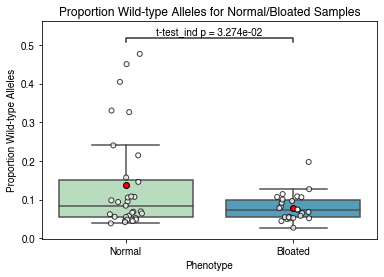

In [12]:
box_strip_plot(["Normal", "Bloated"], "Wild-type", metadata_csv)

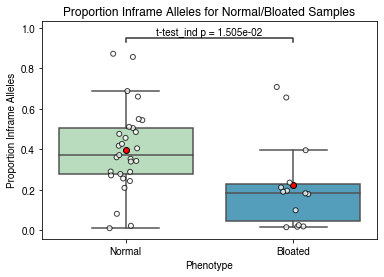

In [13]:
box_strip_plot(["Normal", "Bloated"], "Inframe", metadata_csv)

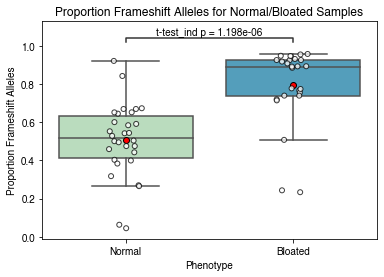

In [14]:
box_strip_plot(["Normal", "Bloated"], "Frameshift", metadata_csv)